# Spatial Integration of ST and MSI

This notebook demonstrates an example workflow for integrating Visium and MSI data.

In [1]:
import os
from os.path import exists, join

import pandas as pd
import SimpleITK as sitk
import matplotlib.pyplot as plt

from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.base_types import Image, Annotation
from miit.spatial_data.spatial_omics.imzml import Imzml
from miit.spatial_data.spatial_omics.visium import Visium
from miit.registerers import GreedyFHistExt
from miit.registerers.other.msi_to_hist_meta_registerer import MSItoHistMetaRegisterer

## 0. Set root directory 

In [2]:
ROOT_DIR = 'test_data/'

# if you follow the docker instructions use this:
# ROOT_DIR = '/external_directory/'

In [3]:
if not exists('output_directory'):
    os.mkdir('output_directory')

## 1. Loading, initial alignment and preprocessing of data.

First, we load both source and target sections and register spatial omics data to the reference image. For details on different data formats, see `01_data_types.ipnb`.

In [4]:
reference_image = Image.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/images/image.tif'))
tissue_mask = Annotation.load_from_path(join(ROOT_DIR, 'test_data/source_data/2/masks/tissue_mask.tif'))
st_data = Visium.from_spcrng(directory=join(ROOT_DIR, 'test_data/source_data/2/spatial_transcriptomics/'))

target_section = Section(reference_image=reference_image,
                  annotations=[tissue_mask])
warped_st_data, registered_image = register_to_ref_image(target_section.reference_image.data, st_data.image.data, st_data)
target_section.so_data.append(warped_st_data)


source_section = Section()

msi_hist_image_path = join(ROOT_DIR, 'test_data/source_data/7/images/image.tif')
msi_hist_image = Image.load_from_path(msi_hist_image_path)
source_section.reference_image = msi_hist_image

imzml_path = join(ROOT_DIR, 'test_data/source_data/7/imzml/reduced_msi.imzML')


imzml = Imzml.init_msi_data(imzml_path, name='negative_ion_mode')
pca_image = imzml.get_pca_img()
registerer = MSItoHistMetaRegisterer()

reg_opts = {'nonrigid': False}

warped_imzml, _ = register_to_ref_image(source_section.reference_image.data, pca_image.data, imzml, registerer, reg_opts)

annotations = Annotation.load_from_path(path_to_data=join(ROOT_DIR, 'test_data/source_data/7/annotations/annotations.nii.gz'),
                                        path_to_labels=join(ROOT_DIR, 'test_data/source_data/7/annotations/labels.txt'),
                                        name='tissue_classes',
                                        channel_idx=0)


source_section.so_data.append(warped_imzml)
source_section.annotations.append(annotations)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(
/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


## 2. Registration


In the 2nd step we perform the registration from the `source_section` to `target_section`. We use the `GreedyFHist` registration algorithm to register both sections.

First, the registerer is initialized, then sections are registered and finally the transformation is applied to the section. By using `apply_transformation`, the transformation is applied to all imaging data within the `source_section`.

In [5]:
registerer = GreedyFHistExt.init_registerer(path_to_greedy='greedy')

In [6]:
transformation = registerer.register_images(
    moving_img=source_section.reference_image.data,
    fixed_img=target_section.reference_image.data
)

In [7]:
warped_section = source_section.apply_transform(registerer, transformation)

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


Text(0.5, 1.0, 'Registered Visium Section')

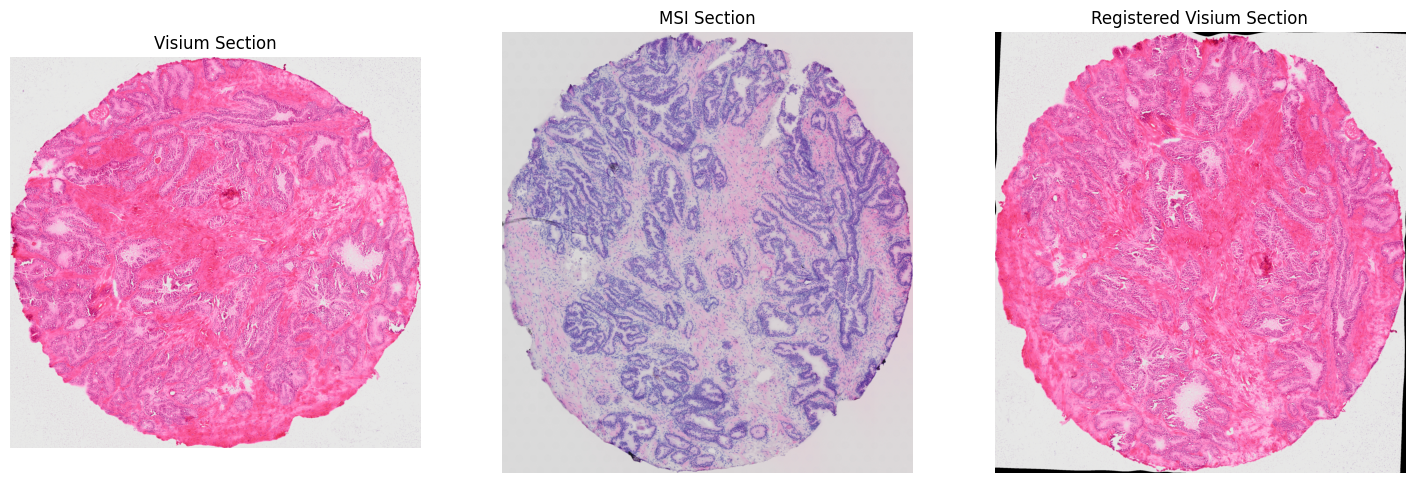

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
for ax in axs:
    ax.axis('off')
axs[0].imshow(source_section.reference_image.data)
axs[0].set_title('Visium Section')
axs[1].imshow(target_section.reference_image.data)
axs[1].set_title('MSI Section')
axs[2].imshow(warped_section.reference_image.data)
axs[2].set_title('Registered Visium Section')

We can also show for the registration affects the reference matrix.

Text(0.5, 1.0, 'MSI Reference Matrix after Registration')

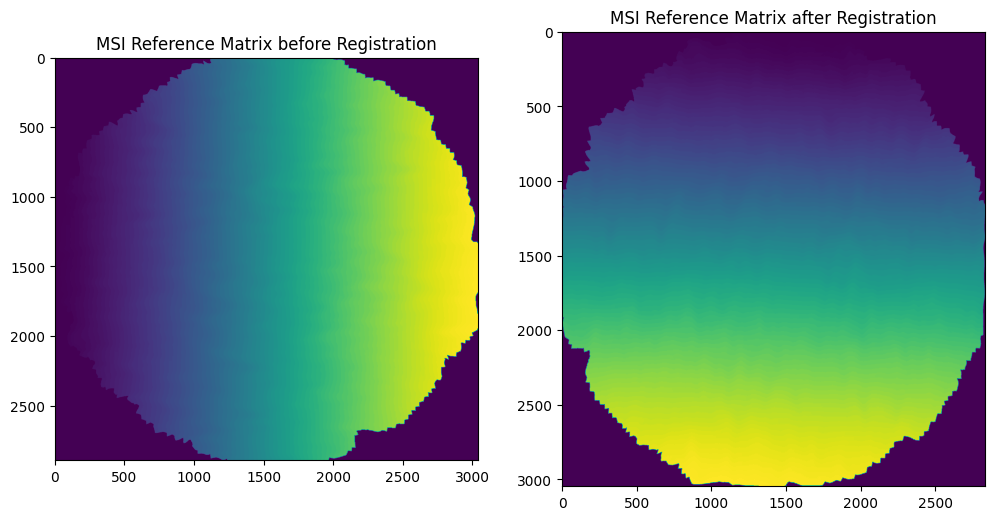

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
msi = source_section.so_data[0]
reg_msi = warped_section.so_data[0]
axs[0].imshow(msi.ref_mat.data)
axs[0].set_title('MSI Reference Matrix before Registration')
axs[1].imshow(reg_msi.ref_mat.data)
axs[1].set_title('MSI Reference Matrix after Registration')

We can also show that the registration worked on annotations.

(-0.5, 2832.5, 3045.5, -0.5)

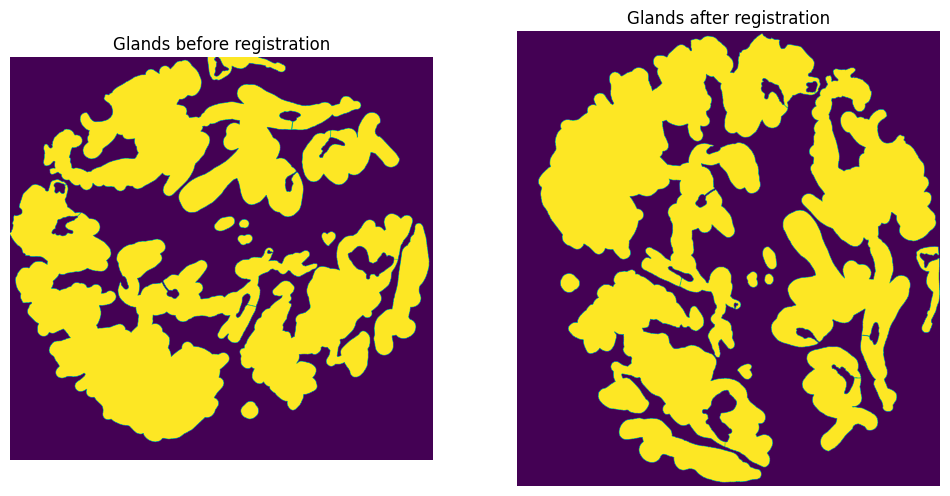

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
warped_annotation = warped_section.get_annotations_by_names('tissue_classes')
axs[0].imshow(annotations.get_by_labels('Normal Glands'))
axs[0].set_title('Glands before registration')
axs[0].axis('off')
axs[1].imshow(warped_annotation.get_by_labels('Normal Glands'))
axs[1].set_title('Glands after registration')
axs[1].axis('off')

## 3. Transformation - MSI to ST

After all spatial data is aligned in the same coordinate system, we transform msi data to the spatial organization of spatial transcriptomics spots.

In [11]:
from miit.spatial_data.spatial_omics.imzml import (
    get_metabolite_intensities_targeted, 
    msi_default_accumulate_spot_weighted_mean, 
    msi_default_spot_accumulation_fun,
    
)
from miit.spatial_data.spatial_omics.visium import convert_table_to_mat
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts,
    transform_annotations_to_table
)
from pyimzml.ImzMLParser import ImzMLParser

Step 1: Find overlap between reference matrix. By default, 0 is assumed to denote the background in each reference matrix. `get_mappings` returns:

- `mapping`: a dictionary that maps for every unique reference id in the source reference matrix, the reference ids (including counts) in the target reference matrix. 
- `spots_background`: for each unique id in the source reference matrix the amount of overlap with background noise in the target reference matrix.
- `unique_target_reference`: A list of unique target references that have overlap with the source reference ids. 

In [12]:
st_data = target_section.so_data[0]
msi_data = warped_section.so_data[0] 
mappings, spots_background, unique_target_reference = get_mappings(st_data.ref_mat.data, msi_data.ref_mat.data, st_data.background, msi_data.background)

Step 2: We extract all intensities from the imzml file. We use the list unique references to only extract pixels which will be relevant for the subsequent merging. 
Row indices indicate the spectrum  and columns indices refer to the enumerated msi-pixels.

In [13]:
msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs)
metabolites_df.head()

,15,16,22,23,24,26,35,36,38,42,...,7659,7674,7677,7678,7680,7681,7682,7683,7684,7685
174.824,14.625623,16.620070,6.201788,14.281237,14.030899,7.584453,10.523711,11.193512,3.490673,7.284834,...,9.548488,11.774512,1.862283,1.751079,2.717426,3.503021,4.269416,3.142743,6.639803,9.730443
191.012,364.073212,312.206909,211.830292,303.801849,379.907074,237.240479,334.556610,284.475067,306.361847,237.315277,...,49.033928,358.702606,209.107758,311.069489,289.171387,358.852631,304.167786,194.722382,242.762833,256.329132


Step 3: We use the msi data and overlapping areas to accumulate the counts over the shared spatial transcriptomics spots.

In this example, we compute the weighted mean to accumulate spots using `msi_default_accumulate_spot_weighted_mean`. 

In [14]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,174.824,191.012
TAGCGTGAATTGGCGT-1,0.319056,20.863137
TACTCTGTAGCATCGG-1,7.467694,376.736847
GGCTAGTCAGGTAGGA-1,4.275511,266.475446
CGTTAATCGAATTGCT-1,11.926279,320.024639
ATATCCTGTCTATCGT-1,12.331769,315.504604


### Alternatives to MSI accumulation

We provide some alternatives to accumulating MSI data for integration. First, we use the same function as before, but add a list of labels. For this, we load a table with a list of identified peaks from a previous publication.

In [15]:
peak_df = pd.read_csv(join(ROOT_DIR, 'test_data/source_data/7/imzml/IdentifiedPeaks.csv'), sep=';')
peak_df.head()

,m/z,Interval Width (+/- Da),Color,Name
0,174.83,0.069932,#b2df8a,Zinc
1,191.02,0.076408,#fdbf6f,Citrate


In [16]:
neg_labels = peak_df.Name.to_list()
msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_target_reference)
msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
msi = ImzMLParser(msi_data.config['imzml'])
metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs, neg_labels)
metabolites_df.head()

/home/maximilw/.local/lib/python3.10/site-packages/pyimzml/ontology/ontology.py:92: UserWarning: Accession IMS:1000046 found with incorrect name "pixel size x". Updating name to "pixel size (x)".
  warn(


,15,16,22,23,24,26,35,36,38,42,...,7659,7674,7677,7678,7680,7681,7682,7683,7684,7685
Zinc,14.625623,16.620070,6.201788,14.281237,14.030899,7.584453,10.523711,11.193512,3.490673,7.284834,...,9.548488,11.774512,1.862283,1.751079,2.717426,3.503021,4.269416,3.142743,6.639803,9.730443
Citrate,364.073212,312.206909,211.830292,303.801849,379.907074,237.240479,334.556610,284.475067,306.361847,237.315277,...,49.033928,358.702606,209.107758,311.069489,289.171387,358.852631,304.167786,194.722382,242.762833,256.329132


In [17]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,Zinc,Citrate
TAGCGTGAATTGGCGT-1,0.319056,20.863137
TACTCTGTAGCATCGG-1,7.467694,376.736847
GGCTAGTCAGGTAGGA-1,4.275511,266.475446
CGTTAATCGAATTGCT-1,11.926279,320.024639
ATATCCTGTCTATCGT-1,12.331769,315.504604


We also provide an additional function, that converts single measurements from tables to their spatial representation in the target image space of st data. 
For this we need a dataframe with barcodes as indices and a `Visium` object.

Text(0.5, 1.0, 'Heatmap of integrated zinc distribution.')

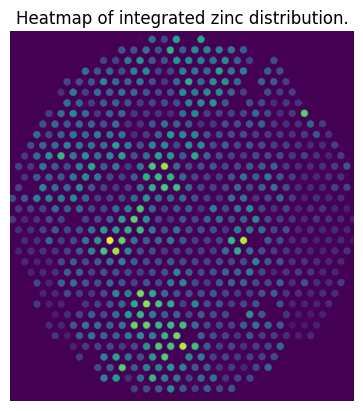

In [18]:
mat = convert_table_to_mat(integrated_df, st_data, 'Zinc')
plt.axis('off')
plt.imshow(mat)
plt.title('Heatmap of integrated zinc distribution.')

Another alternative to using the weighted mean to accumulate to spots, can be used with `msi_default_spot_accumulation_fun`. By default, this method accumulated using a number of standard statistical functions (i.e. max, mean median, min, std).

In [19]:
accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_spot_accumulation_fun)
integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
integrated_df.head()

,max_Citrate,mean_Citrate,median_Citrate,min_Citrate,std_Citrate,max_Zinc,mean_Zinc,median_Zinc,min_Zinc,std_Zinc,n_bck_pixls,n_pixels
TAGCGTGAATTGGCGT-1,315.813293,20.863137,0.000000,0.000000,72.011056,5.937024,0.319056,0.000000,0.000000,1.186758,2577,2797
TACTCTGTAGCATCGG-1,415.331268,376.736847,378.001251,224.468369,43.399755,11.510142,7.467694,7.426965,5.218772,1.620475,0,2749
GGCTAGTCAGGTAGGA-1,421.013306,266.475446,286.435577,173.210083,68.521157,10.378397,4.275511,4.716009,2.159183,1.913514,0,2751
CGTTAATCGAATTGCT-1,424.945587,320.024639,303.801849,211.830292,75.819790,14.955336,11.926279,13.520127,6.201788,3.482093,0,2788
ATATCCTGTCTATCGT-1,364.073212,315.504604,312.206909,284.475067,30.231730,16.620070,12.331769,11.193512,10.523711,2.192747,0,2723


Finally, all previous examples used an imzML file with preselected metabolite intensities. We also have functionality for dealing with imzML files containing prefiltered spectra. Intensity values from full spectra can be extracted using the function `get_metabolite_intensities_from_full_spectrum`.

### 3. Transformation - Annotations to ST organization

Another example is, that we can transform annotations onto the ST organization.

In [20]:
integrated_annotation = transform_annotations_to_table(target_section.so_data[0], warped_annotation)

In [21]:
integrated_annotation

,Empty,Stroma,Normal Glands,ISUP1,ISUP2,ISUP3,ISUP4,ISUP5,ISUPY,ISUPX,Lymphocytes,Lymphocyte_enriched_stroma,PNI,PIN,Tissue,Vessel,Stone,Uncertain,Lumen
TAGCGTGAATTGGCGT-1,0.0,0.000000,0.000715,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.766893,0.0,0.0,0.0,0.0
TACTCTGTAGCATCGG-1,0.0,0.000000,0.451801,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.968716,0.0,0.0,0.0,0.0
GGCTAGTCAGGTAGGA-1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
CGTTAATCGAATTGCT-1,0.0,0.218077,0.259326,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.776184,0.0,0.0,0.0,0.0
ATATCCTGTCTATCGT-1,0.0,0.454646,0.392214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.950790,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCTATTCGCCCAGACA-1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
GCTCCGCCGAATCGTC-1,0.0,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
CTGAACATGCGTGACG-1,0.0,0.546875,0.453125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
CTGCCCCTTATGGAAC-1,0.0,1.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0


We can use `convert_table_to_mat` on annotations as well.

Text(0.5, 1.0, 'Stroma distribution over ST data.')

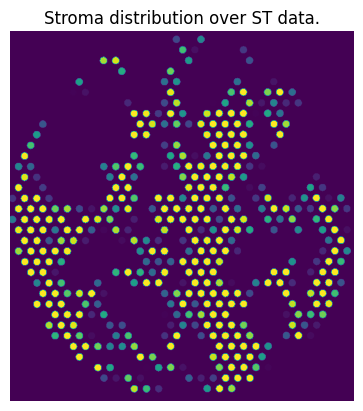

In [22]:
mat = convert_table_to_mat(integrated_annotation, st_data, 'Stroma')
plt.axis('off')
plt.imshow(mat)
plt.title('Stroma distribution over ST data.')

## 4. Export

In this example we simply export the data to the `csv` format. For an example on exporting to `imzml` format, see `03_integrate_msi_and_msi`.

In [23]:
integrated_df.to_csv('output_directory/integrated_msi.csv')

In [24]:
integrated_annotation.to_csv('output_directory/integrated_annotation.csv')